<a href="https://colab.research.google.com/github/Sabir123556/Batch22_1506/blob/main/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['Company Names', 'Cars Names', 'Engines', 'CC/Battery Capacity',
       'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices',
       'Fuel Types', 'Seats', 'Torque'],
      dtype='object')

DataFrame info before dropping NaNs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Company Names              1218 non-null   object 
 1   Cars Names                 1218 non-null   object 
 2   Engines                    1218 non-null   object 
 3   CC/Battery Capacity        1215 non-null   object 
 4   HorsePower                 1208 non-null   float64
 5   Total Speed                1218 non-null   float64
 6   Performance(0 - 100 )KM/H  1212 non-null   object 
 7   Cars Prices                1212 non-null   float64
 8   Fuel Types                 1218 non-null   object 
 9   Seats              

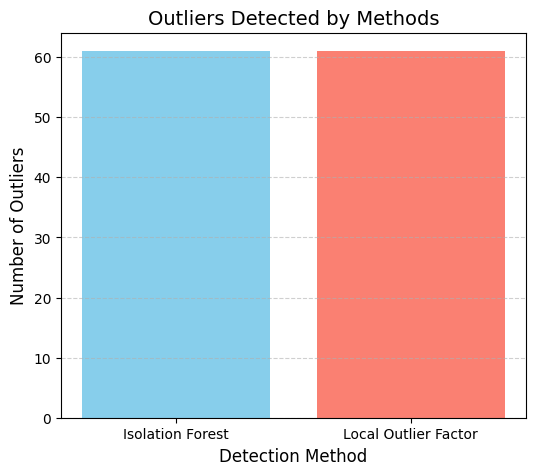

In [15]:
# -------------------------------
# Outlier Detection Module with Visualization
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

# Load the preprocessed dataset
df = pd.read_csv("/content/Cars Datasets 2025.csv", encoding='latin-1')

# Clean up column names by removing leading/trailing spaces
df.columns = df.columns.str.strip()

# Print column names to inspect
print(df.columns)

# Function to clean and convert columns to numeric
def clean_and_convert_numeric(series):
    series = series.astype(str).str.lower()
    # Remove units and symbols
    series = series.str.replace('hp', '', regex=False)
    series = series.str.replace('nm', '', regex=False)
    series = series.str.replace('km/h', '', regex=False)
    series = series.str.replace('$', '', regex=False)
    series = series.str.replace(',', '', regex=False)
    series = series.str.replace('up to', '', regex=False)
    series = series.str.replace('(est.)', '', regex=False)
    series = series.str.replace('(electric)', '', regex=False)
    series = series.str.replace('cc', '', regex=False)
    series = series.str.replace(' ', '', regex=False)
    series = series.str.replace('–', '-', regex=False) # Replace en dash with hyphen

    # Handle ranges by taking the average
    def handle_range(value):
        if '-' in value:
            try:
                low, high = map(float, value.split('-'))
                return (low + high) / 2
            except ValueError:
                return np.nan
        else:
            try:
                return float(value)
            except ValueError:
                return np.nan

    return series.apply(handle_range)


# Convert relevant columns to numeric using the cleaning function
cols_to_clean_convert = ["HorsePower", "Torque", "Total Speed", "Cars Prices"]
for col in cols_to_clean_convert:
    df[col] = clean_and_convert_numeric(df[col])

# Print info before dropping NaNs
print("\nDataFrame info before dropping NaNs:")
df.info()
print("\nNumber of NaNs per column before dropping:")
print(df[cols_to_clean_convert].isnull().sum())

# Drop rows with NaN values in the relevant columns after conversion
initial_rows = df.shape[0]
df.dropna(subset=cols_to_clean_convert, inplace=True)
rows_after_dropping = df.shape[0]

print(f"\nNumber of rows before dropping NaNs: {initial_rows}")
print(f"Number of rows after dropping NaNs: {rows_after_dropping}")

# Compute Performance-to-Cost Ratio (example formula)
df["Performance_to_Cost"] = (df["HorsePower"] + df["Torque"] + df["Total Speed"]) / (df["Cars Prices"] + 1e-6)

# Select features for outlier detection
features = ["Total Speed", "HorsePower", "Torque", "Cars Prices", "Performance_to_Cost"]
X = df[features]

# -------------------------------
# 1. Isolation Forest
# -------------------------------
iso = IsolationForest(contamination=0.05, random_state=42)  # 5% expected outliers
df["Outlier_IForest"] = iso.fit_predict(X)

# Label interpretation: -1 = outlier, 1 = inlier
print("\nIsolation Forest Outliers:", (df["Outlier_IForest"] == -1).sum())

# -------------------------------
# 2. Local Outlier Factor (LOF)
# -------------------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df["Outlier_LOF"] = lof.fit_predict(X)

print("LOF Outliers:", (df["Outlier_LOF"] == -1).sum())

# -------------------------------
# Save Results
# -------------------------------
df.to_csv("cars_2025_outliers.csv", index=False)
print("\nOutlier detection complete! Results saved in cars_2025_outliers.csv")

# -------------------------------
# Visualization - Bar Graph
# -------------------------------
outlier_counts = {
    "Isolation Forest": (df["Outlier_IForest"] == -1).sum(),
    "Local Outlier Factor": (df["Outlier_LOF"] == -1).sum()
}

plt.figure(figsize=(6,5))
plt.bar(outlier_counts.keys(), outlier_counts.values(), color=['skyblue', 'salmon'])
plt.title("Outliers Detected by Methods", fontsize=14)
plt.ylabel("Number of Outliers", fontsize=12)
plt.xlabel("Detection Method", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
